In [1]:
import os
import glob
import numpy as np
import sklearn
import skimage
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.plot import reshape_as_raster
from skimage.exposure import rescale_intensity
import pickle
from functools import partial

from matplotlib import pyplot as plt
import time
from tqdm.notebook import tqdm

# from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor, as_completed
from dask.distributed import Client, progress

In [2]:
print(sklearn.__version__)
print(skimage.__version__)

1.3.0
0.18.2


In [3]:
from src.utils.load import load_features
from src.utils.utils import colorize_dynamic_world

In [4]:
# create a hub to control the workers
c = Client()

In [5]:
YEAR = 2023
STATE = "washington"

In [6]:
TILES = f"../data/interim/{STATE}_quarter_quads.shp"
tiles = gpd.read_file(TILES)
tiles.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5772 entries, 0 to 5771
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    5772 non-null   int64   
 1   CELL_ID     5772 non-null   int64   
 2   CELL_NAME   5772 non-null   object  
 3   PRIMARY_ST  5772 non-null   object  
 4   CELL_MAPCO  5772 non-null   object  
 5   CELL_TYPE   5772 non-null   int64   
 6   CELL_ALLWA  5772 non-null   int64   
 7   CELL_DESCR  4 non-null      object  
 8   CELL_DIACR  0 non-null      float64 
 9   GLOBALID    5772 non-null   object  
 10  SHAPE_Leng  5772 non-null   float64 
 11  SHAPE_Area  5772 non-null   float64 
 12  geometry    5772 non-null   geometry
dtypes: float64(3), geometry(1), int64(4), object(5)
memory usage: 586.3+ KB


In [7]:
MODEL = "../models/global-sentinel-HistGradientBoostingRegressor-multioutput.pkl"
# MODEL = "../models/global-sentinel-HistGradientBoostingRegressor-chained.pkl"
model = pickle.load(open(MODEL, "rb"))

/home/ygalvan/mambaforge/envs/landmapper-test/lib/python3.9/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.2.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ygalvan/mambaforge/envs/landmapper-test/lib/python3.9/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator HistGradientBoostingRegressor from version 1.2.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ygalvan/mambaforge/envs/landmapper-test/lib/python3.9/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying t

In [8]:
BAND_DESCRIPTIONS = {
    1: "Canopy Cover",
    2: "Dominant Height",
    3: "Live Tree Basal Area",
    4: "Quadratic Mean Diameter",
    5: "Trees Per Acre (Growing Stock)",
    6: "Aboveground Live Tree Biomass",
    7: "Dynamic World Land Cover",
}
BAND_UNITS = {
    1: "Percent",
    2: "Feet",
    3: "Square feet per acre",
    4: "Inches",
    5: "Trees Per Acre",
    6: "",
    7: "",
}

In [9]:
def load_predict(cell_id, year, state, overwrite=False):
    dwfile = f"../data/interim/{state}_imagery/dynamic_world/{cell_id}_dynamicworld{year}.tif"
    X = load_features(f"../data/interim/{state}_imagery", cell_id, year)

    with rasterio.open(
        f"../data/interim/{state}_imagery/sentinel/{cell_id}_sentinel{year}.tif"
    ) as src:
        profile = src.profile
        height, width = profile["height"], profile["width"]
    # check for nodata in input dataframe
    pred = model.predict(X)
    for i in range(pred.shape[1]):
        if i == 0:
            pred[:, i] = np.clip(pred[:, i], 0, 100)  # clip canopy cover to 0-100
        else:
            pred[:, i] = np.clip(pred[:, i], 0, None)  # clip negative structure values
    pred = pred.reshape((height, width, 6))

    with rasterio.open(dwfile) as dw_src:
        dw = dw_src.read(1)

    profile.update(nodata=-9999, count=7, dtype="int16")

    pred[:][~np.isin(dw, [1, 5])] = profile["nodata"]

    pred_ras = reshape_as_raster(pred).astype("int16")
    # for i, band in enumerate(pred_ras):
    #     # max_val = 100 if i == 0 else None
    #     # pred_ras[i] = np.clip(band, 0, None)

    return np.vstack((pred_ras, dw.reshape(1, height, width))), profile

In [10]:
def load_predict_save(cell_id, year, state, overwrite=False):
    outfile = f"../data/processed/{state}/predictions/{cell_id}_structure{year}.tif"
    if not os.path.exists(outfile) or overwrite:
        try:
            pred_ras, profile = load_predict(cell_id, year, state)

            with rasterio.open(outfile, "w", **profile) as dst:
                for i in range(profile["count"]):
                    dst.write(pred_ras[i], i + 1)
                    dst.set_band_description(i + 1, BAND_DESCRIPTIONS[i + 1])
                    dst.set_band_unit(i + 1, BAND_UNITS[i + 1])

        except Exception as e:
            print("Failed on", cell_id, e)
    return cell_id

In [11]:
to_run = [
    os.path.basename(f).split("_")[0]
    for f in glob.glob(f"../data/interim/{STATE}_imagery/sentinel/*{YEAR}.tif")
]

In [12]:
len(to_run)

10

In [13]:
os.makedirs(f"../data/processed/{STATE}/predictions/", exist_ok=True)

In [14]:
CELL_ID = np.random.choice(to_run)

with rasterio.open(
    f"../data/interim/{STATE}_imagery/sentinel/{CELL_ID}_sentinel{YEAR}.tif"
) as src:
    height, width = src.height, src.width
    img = src.read()
    profile = src.profile

pred, prof = load_predict(CELL_ID, YEAR, STATE)
pred = np.ma.masked_values(pred, -9999)

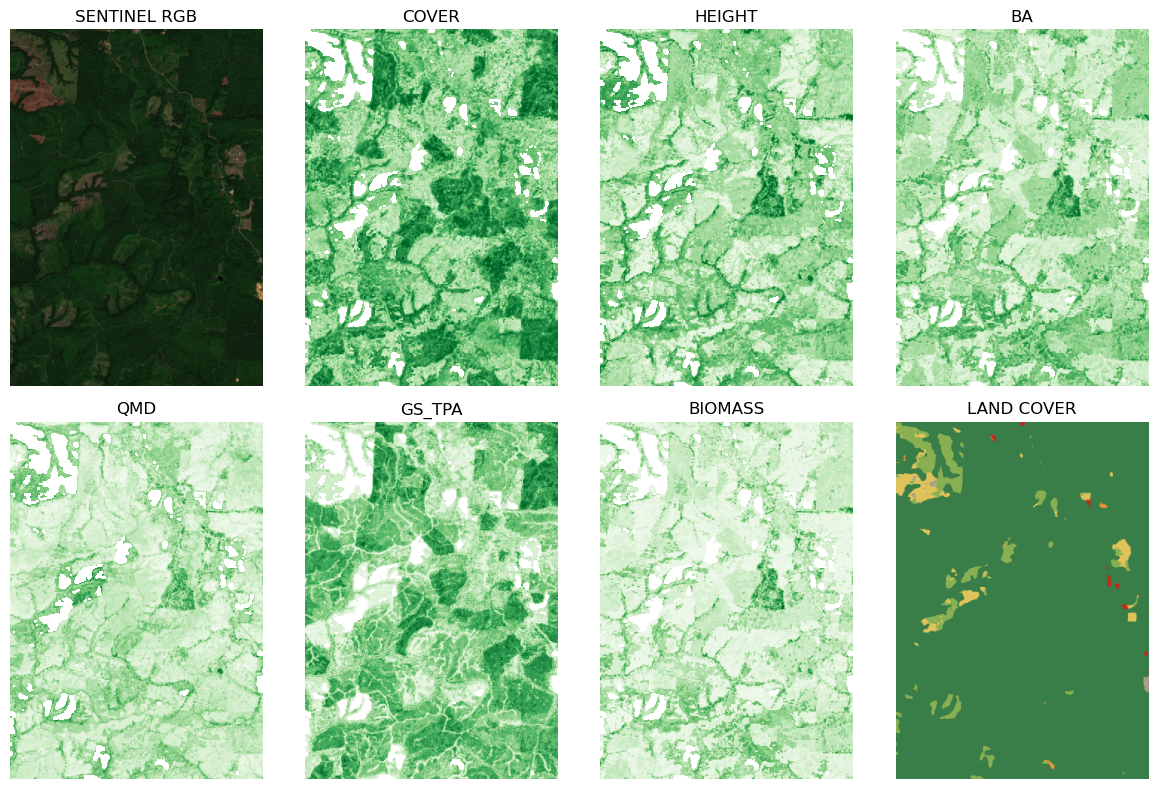

In [15]:
fig, axs = plt.subplots(2, 4, figsize=(12, 8))
axs.ravel()[0].imshow(
    rescale_intensity(
        np.dstack((img[2], img[1], img[0])), in_range=(0, 3000), out_range="uint8"
    ).astype("uint8")
)
TITLES = [
    "SENTINEL RGB",
    "COVER",
    "HEIGHT",
    "BA",
    "QMD",
    "GS_TPA",
    "BIOMASS",
    "LAND COVER",
]
for i in range(8):
    axs.ravel()[i].set_title(TITLES[i])
    axs.ravel()[i].axis("off")
    if i == 7:
        axs.ravel()[i].imshow(colorize_dynamic_world(pred[i - 1]))
    elif i > 0:
        axs.ravel()[i].imshow(pred[i - 1] / pred[i - 1].max(), cmap="Greens")

plt.tight_layout()
plt.show()

In [16]:
pred.max(axis=(1, 2)).data, pred.mean(axis=(1, 2)).data, pred.min(axis=(1, 2)).data

(array([ 98, 145, 374,  28, 545, 125,   7], dtype=int16),
 array([ 56.83770806,  64.38656878, 126.01446314,   9.37128033,
        240.96185678,  28.97895168,   1.13766368]),
 array([10, 16,  1,  2,  0,  0,  1], dtype=int16))

In [15]:
can_run = [
    os.path.basename(f).split("_")[0]
    for f in glob.glob(f"../data/interim/{STATE}_imagery/sentinel/*{YEAR}.tif")
]
already_run = [
    os.path.basename(f).split("_")[0]
    for f in glob.glob(f"../data/processed/{STATE}/predictions/*")
]
to_run = [x for x in can_run if x not in already_run]

In [16]:
# load_predict_save(314753, year=2022, state='washington')

In [17]:
# to_run = np.unique(tiles.CELL_ID.values)

In [18]:
# with tqdm(total=len(to_run)) as pbar:
#     completed = []
#     with ThreadPoolExecutor(4) as executor: # 12 mins for 130 predictions
#         # with parallel_backend('loky', n_jobs=1):
#         jobs = [executor.submit(load_predict_save, cell_id, YEAR, STATE) for cell_id in to_run]
#         for job in as_completed(jobs):
#             completed.append(job.result())
#             pbar.update()

In [19]:
# start batch
run_model = partial(load_predict_save, year=YEAR, state=STATE)

In [20]:
res = c.map(run_model, to_run)
print("Started batch processing.")

Started batch processing.


In [21]:
with tqdm(total=len(can_run), smoothing=0.7) as pbar:
    finished = len(glob.glob(f"../data/processed/{STATE}/predictions/*.tif"))
    pbar.update(finished)
    while finished < len(can_run):
        now = len(glob.glob(f"../data/processed/{STATE}/predictions/*.tif"))
        pbar.update(now - finished)
        finished = now
        time.sleep(0.1)

  0%|          | 0/5772 [00:00<?, ?it/s]

In [22]:
# c.close()

In [23]:
# c.cancel(res)